# 3D classification example based on DenseNet

This tutorial shows an example of 3D classification task based on DenseNet and array format transforms.

Here, the task is given to classify MR images into male/female.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/3d_classification/torch/densenet_training_array.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"

## Setup imports

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import os
import sys
import tempfile
import shutil

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, ImageDataset
from monai.transforms import (
    AddChannel,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
    EnsureType,
    Randomizable,
    LoadImaged,
    EnsureTyped,
)

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

MONAI version: 0.4.0+35.g6adbcde
Numpy version: 1.19.5
Pytorch version: 1.7.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 6adbcdee45c16f18f5b713575af3410437177311

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 7.0.0
Tensorboard version: 2.4.0
gdown version: 3.12.2
TorchVision version: 0.8.2
ITK version: 5.1.2
tqdm version: 4.51.0
lmdb version: 1.0.0
psutil version: 5.8.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/data/medical


In [4]:
class IXIDataset(Randomizable, CacheDataset):
    resource = "http://biomedic.doc.ic.ac.uk/" \
        + "brain-development/downloads/IXI/IXI-T1.tar"
    md5 = "34901a0593b41dd19c1a1f746eac2d58"

    def __init__(
        self,
        root_dir,
        section,
        transform,
        download=False,
        seed=0,
        val_frac=0.2,
        test_frac=0.2,
        cache_num=sys.maxsize,
        cache_rate=1.0,
        num_workers=0,
    ):
        if not os.path.isdir(root_dir):
            raise ValueError("Root directory root_dir must be a directory.")
        self.section = section
        self.val_frac = val_frac
        self.test_frac = test_frac
        self.set_random_state(seed=seed)
        dataset_dir = os.path.join(root_dir, "ixi")
        tarfile_name = f"{dataset_dir}.tar"
        if download:
            download_and_extract(
                self.resource, tarfile_name, dataset_dir, self.md5)
        # as a quick demo, we just use 10 images to show

        self.datalist = [
            {"image": os.path.join(
                dataset_dir, "IXI314-IOP-0889-T1.nii.gz"), "label": 0},
            {"image": os.path.join(
                dataset_dir, "IXI249-Guys-1072-T1.nii.gz"), "label": 0},
            {"image": os.path.join(
                dataset_dir, "IXI609-HH-2600-T1.nii.gz"), "label": 0},
            {"image": os.path.join(
                dataset_dir, "IXI173-HH-1590-T1.nii.gz"), "label": 1},
            {"image": os.path.join(
                dataset_dir, "IXI020-Guys-0700-T1.nii.gz"), "label": 0},
            {"image": os.path.join(
                dataset_dir, "IXI342-Guys-0909-T1.nii.gz"), "label": 0},
            {"image": os.path.join(
                dataset_dir, "IXI134-Guys-0780-T1.nii.gz"), "label": 0},
            {"image": os.path.join(
                dataset_dir, "IXI577-HH-2661-T1.nii.gz"), "label": 1},
            {"image": os.path.join(
                dataset_dir, "IXI066-Guys-0731-T1.nii.gz"), "label": 1},
            {"image": os.path.join(
                dataset_dir, "IXI130-HH-1528-T1.nii.gz"), "label": 0},
        ]
        data = self._generate_data_list()
        super().__init__(
            data, transform, cache_num=cache_num,
            cache_rate=cache_rate, num_workers=num_workers,
        )

    def randomize(self, data=None):
        self.rann = self.R.random()

    def _generate_data_list(self):
        data = []
        for d in self.datalist:
            self.randomize()
            if self.section == "training":
                if self.rann < self.val_frac + self.test_frac:
                    continue
            elif self.section == "validation":
                if self.rann >= self.val_frac:
                    continue
            elif self.section == "test":
                if self.rann < self.val_frac or \
                        self.rann >= self.val_frac + self.test_frac:
                    continue
            else:
                raise ValueError(
                    f"Unsupported section: {self.section}, "
                    "available options are ['training', 'validation', 'test']."
                )
            data.append(d)
        return data

In [5]:
train_ds = IXIDataset(
    root_dir=root_dir,
    section="training",
    transform=Compose([LoadImaged("image"), EnsureTyped("image")]),
    download=True,
)

Verified 'ixi.tar', md5: 34901a0593b41dd19c1a1f746eac2d58.
file /workspace/data/medical/ixi.tar exists, skip downloading.
Verified 'ixi.tar', md5: 34901a0593b41dd19c1a1f746eac2d58.


100%|██████████| 9/9 [00:02<00:00,  3.63it/s]


In [6]:
# IXI dataset as a demo, downloadable from https://brain-development.org/ixi-dataset/
images = [
    os.sep.join([root_dir, "ixi", "IXI314-IOP-0889-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI249-Guys-1072-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI609-HH-2600-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI173-HH-1590-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI020-Guys-0700-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI342-Guys-0909-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI134-Guys-0780-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI577-HH-2661-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI066-Guys-0731-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI130-HH-1528-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI607-Guys-1097-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI175-HH-1570-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI385-HH-2078-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI344-Guys-0905-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI409-Guys-0960-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI584-Guys-1129-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI253-HH-1694-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI092-HH-1436-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI574-IOP-1156-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI585-Guys-1130-T1.nii.gz"]),
]

# 2 binary labels for gender classification: man and woman
labels = np.array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
                   0, 1, 0, 1, 0, 1, 0], dtype=np.int64)

# Define transforms
train_transforms = Compose([ScaleIntensity(), AddChannel(), Resize(
    (96, 96, 96)), RandRotate90(), EnsureType()])
val_transforms = Compose(
    [ScaleIntensity(), AddChannel(), Resize((96, 96, 96)), EnsureType()])

# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=images, labels=labels,
                        transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=2,
                          num_workers=2, pin_memory=torch.cuda.is_available())
im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label)

# create a training data loader
train_ds = ImageDataset(
    image_files=images[:10], labels=labels[:10], transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True,
                          num_workers=2, pin_memory=torch.cuda.is_available())

# create a validation data loader
val_ds = ImageDataset(
    image_files=images[-10:], labels=labels[-10:], transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=2, num_workers=2,
                        pin_memory=torch.cuda.is_available())

# Create DenseNet121, CrossEntropyLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.DenseNet121(
    spatial_dims=3, in_channels=1, out_channels=2).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 5
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            num_correct = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(
                    device), val_data[1].to(device)
                val_outputs = model(val_images)
                value = torch.eq(val_outputs.argmax(dim=1), val_labels)
                metric_count += len(value)
                num_correct += value.sum().item()
            metric = num_correct / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(),
                           "best_metric_model_classification3d_array.pth")
                print("saved new best metric model")
            print(
                "current epoch: {} current accuracy: {:.4f} "
                "best accuracy: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
            writer.add_scalar("val_accuracy", metric, epoch + 1)
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")
writer.close()

<class 'torch.Tensor'> torch.Size([2, 1, 96, 96, 96]) tensor([0, 0])
----------
epoch 1/5
1/5, train_loss: 0.6933
2/5, train_loss: 0.7689
3/5, train_loss: 0.7098
4/5, train_loss: 0.6135
5/5, train_loss: 0.7706
epoch 1 average loss: 0.7112
----------
epoch 2/5
1/5, train_loss: 0.7779
2/5, train_loss: 0.7371
3/5, train_loss: 0.7766
4/5, train_loss: 0.5238
5/5, train_loss: 0.6517
epoch 2 average loss: 0.6934
saved new best metric model
current epoch: 2 current accuracy: 0.6000 best accuracy: 0.6000 at epoch 2
----------
epoch 3/5
1/5, train_loss: 0.7595
2/5, train_loss: 0.6735
3/5, train_loss: 0.4000
4/5, train_loss: 0.6529
5/5, train_loss: 0.7401
epoch 3 average loss: 0.6452
----------
epoch 4/5
1/5, train_loss: 0.8956
2/5, train_loss: 0.6899
3/5, train_loss: 0.7104
4/5, train_loss: 0.7479
5/5, train_loss: 0.7186
epoch 4 average loss: 0.7525
current epoch: 4 current accuracy: 0.6000 best accuracy: 0.6000 at epoch 2
----------
epoch 5/5
1/5, train_loss: 0.7230
2/5, train_loss: 0.6702
3/5,

# Occlusion sensitivity
One method for trying to visualise why the network made a given prediction is occlusion sensitivity. We occlude part of the image, and see how the probability of a given prediction changes. We then iterate over the image, moving the occluded portion as we go, and in doing so we build up a sensitivity map detailing which areas were the most important in making the decision.

#### Bounds
If we were to test the occlusion centred on all voxels in our image, we would have to do `torch.prod(im.shape) = 96^3 = ~1e6` predictions. We can use the bounding box to only to the estimations in a region of interest, for example over one slice.

To do this, we simply give the bounding box as `(minC,maxC,minD,maxD,minH,maxH,minW,maxW)`. We can use `-1` for any value to use its full extent (`0` and `im.shape-1` for min's and max's, respectively).

#### Output
The output image in this example will look fairly bad, since our network hasn't been trained for very long. Training for longer should improve the quality of the occlusion map.

In [7]:
# create a validation data loader
test_ds = ImageDataset(
    image_files=images[-10:], labels=labels[-10:], transform=val_transforms)
test_loader = DataLoader(val_ds, batch_size=1, num_workers=2,
                         pin_memory=torch.cuda.is_available())
itera = iter(test_loader)


def get_next_im():
    test_data = next(itera)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)


def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

In [8]:
# Get a random image and its corresponding label
img, label = get_next_im()

Computing occlusion sensitivity: 100%|██████████| 64/64 [00:00<00:00, 143.99it/s]


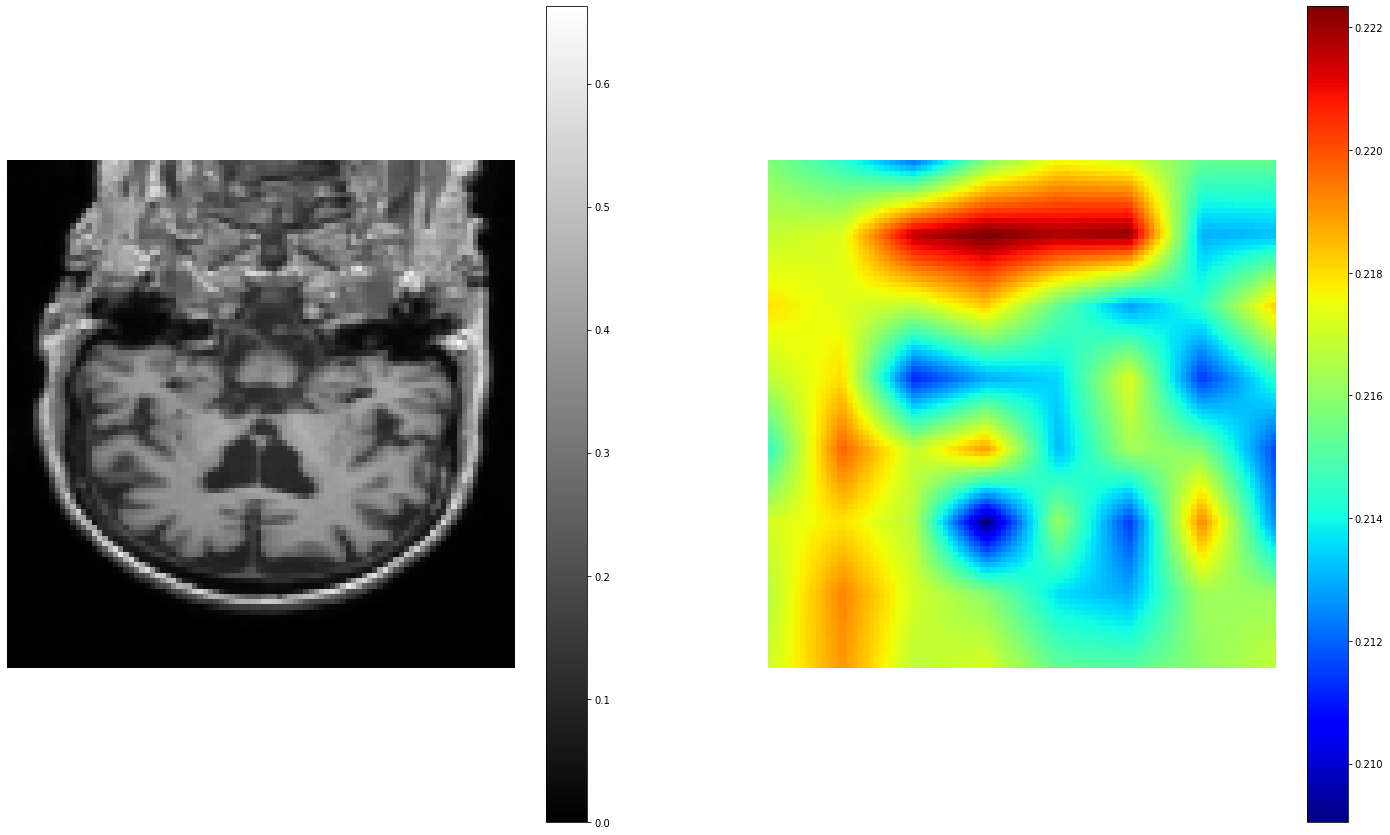

In [9]:
# Get the occlusion sensitivity map
occ_sens = monai.visualize.OcclusionSensitivity(
    nn_module=model, mask_size=12, n_batch=10, stride=12)
# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively
depth_slice = img.shape[2] // 2
occ_sens_b_box = [-1, -1, depth_slice, depth_slice, -1, -1, -1, -1]

occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box)
occ_result = occ_result[..., label.item()]

fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor='white')

for i, im in enumerate([img[:, :, depth_slice, ...], occ_result]):
    cmap = 'gray' if i == 0 else 'jet'
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis('off')
    fig.colorbar(im_show, ax=ax)

## Cleanup data directory

Remove directory if a temporary was used.

In [10]:
if directory is None:
    shutil.rmtree(root_dir)